In [1]:
import Parity_Data_Generator
import numpy as np
from newESN import ESN
import matplotlib.pyplot as plt
import time

rng = np.random.RandomState(42)

N = 4000   
n = 3       # n-parity
timescale=50

start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
# train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00800180435180664 seconds ---


In [2]:
def runSomeConfigs(spectral_rad, leak_r, d_t, train_b, test_b, train_t, test_t, n_neurons):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    scale = 1/np.std(train_b)
    shift = -np.mean(train_b)/np.std(train_b)
    nParityESN = ESN(inputs=1,
                          neurons=n_neurons,  
                          spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= leak_r,   # adjust leak_rate
                          dt= d_t,
                          sparsity=0.95,
                          noise=0.01,
                          input_scale=scale,
                          input_shift=shift)
    # print(np.shape(bits),np.shape(parity),np.shape(target))
    nParityESN.train(train_b, train_t)
    pred_test = nParityESN.predict(test_b)

    predictedParity = pred_test 
    
    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_t) ** 2))
    print(test_error)
    return test_error

def produceTrainingData(i):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
#     train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    return train_bits, test_bits, train_targets, test_targets

In [3]:
trials=50
sp_rad = np.linspace(0.1, 2, num=10)
l_rate = np.linspace(0.1, 1.5, num=10)
num_neurons = 50
delta_t = [0.1]

run_time = time.time()
iterations, iterationcount = trials*len(sp_rad)*len(l_rate)*len(delta_t), 0

delta_t_error = []
for dt in delta_t:
    all_errors = [{} for _ in range(trials)] # empty dict
    for i in range(trials):
        errors = []
        # produce training and testing data
        train_bits, test_bits, train_target, test_target = produceTrainingData(i)
        for l in l_rate:
            for s in sp_rad:
                print("Neurons:", num_neurons,"Leak-rate:",l,"Spectral-radius:",s,"Delta_t:",dt)
                errors.append(runSomeConfigs(s,l,dt, train_bits, test_bits, train_target, test_target, num_neurons))
                iterationcount = iterationcount + 1
                print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
        ## Save leak-rate,spectral-radius and error in dictionary
        all_errors[i] = errors

    ### Average errors
    errors_averaged_over_trials = np.zeros(100)
    for i in range(len(all_errors)):
        e = all_errors[i]
        errors_averaged_over_trials = np.add(errors_averaged_over_trials, np.array(e))
    errors_averaged_over_trials = np.divide(errors_averaged_over_trials, trials)
    
    delta_t_error.append(errors_averaged_over_trials)
    
print("Total time:")
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.1 Delta_t: 0.1


C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:


Testing error
0.424476614664
--- Progress: 0.02% --- 0.08 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.311111111111 Delta_t: 0.1
Testing error
0.418576507822
--- Progress: 0.04% --- 0.16 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.522222222222 Delta_t: 0.1
Testing error
0.390414569742
--- Progress: 0.06% --- 0.25 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.733333333333 Delta_t: 0.1
Testing error
0.504090148911
--- Progress: 0.08% --- 0.35 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 0.944444444444 Delta_t: 0.1
Testing error
0.421356588736
--- Progress: 0.10% --- 0.43 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 1.15555555556 Delta_t: 0.1
Testing error
0.4370426692
--- Progress: 0.12% --- 0.52 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 1.36666666667 Delta_t: 0.1
Testing error
0.388006518518
--- Progress: 0.14% --- 0.60 minutes ---
Neurons: 50 Leak-rate: 0.1 Spectral-radius: 1.57777777778 Delta_t: 0.1
Testing err

In [15]:
import pickle
#### Save Data
# with open('picklefiles/bigESN50newClassaveraged50largespradlrateWithScaleShift.p', 'wb') as outputFile:
#     pickle.dump(delta_t_error, outputFile)
#     pickle.dump(num_neurons, outputFile)
#     pickle.dump(delta_t, outputFile)
#     pickle.dump(trials, outputFile)
#     pickle.dump(l_rate, outputFile)
#     pickle.dump(sp_rad, outputFile)
#### Load Data
with open('picklefiles/bigESNnewClassaveraged10largespradlrateWithScaleShift.p', 'rb') as inputFile:
    delta_t_error = pickle.load(inputFile)
    num_neurons = pickle.load(inputFile)
    delta_t = pickle.load(inputFile)
    trials = pickle.load(inputFile)
    l_rate = pickle.load(inputFile)
    sp_rad = pickle.load(inputFile)

0.180016532796
leak-rate 0.722222222222
sp_rad 1.36666666667


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


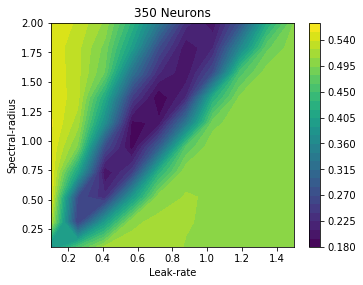

In [16]:
### Plot Errors
import numpy as np
from matplotlib import pyplot
%matplotlib inline
xx, yy = np.meshgrid(l_rate, sp_rad)
pyplot.figure(figsize=(12,14))
for p in range(len(delta_t)):
    pyplot.subplot(3,2,p+1)
    pyplot.contourf(xx,
                    yy,delta_t_error[p].reshape(10,10).T,30)
    pyplot.title("350 Neurons")
#     pyplot.plot(l_rate[np.argmin(delta_t_error[0].reshape(10,10).T)%10],sp_rad[np.argmin(delta_t_error[0].reshape(10,10).T)/10],"wx")
    pyplot.xlabel("Leak-rate")
    pyplot.ylabel("Spectral-radius")
    pyplot.colorbar()
print(np.min(delta_t_error[0]))
print("leak-rate",l_rate[np.argmin(delta_t_error[0].reshape(10,10).T)%10])
print("sp_rad",sp_rad[np.argmin(delta_t_error[0].reshape(10,10).T)/10])

In [8]:
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(22))

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
#     train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

scale = 1/np.std(train_bits)
shift = -np.mean(train_bits)/np.std(train_bits)
bigESN = ESN(inputs=1,
                  neurons=50,  
                  spectral_radius=0.5,  # high spectral rad is better (high fluctuations 0->1->0)
                  leak_rate= 0.25,   # adjust leak_rate
                  dt= 0.1,
                  sparsity=0.95,
                  noise=0.01,
                  input_scale=scale,
                  input_shift=shift)
bigESN.train(train_bits, train_targets)#, inspect= True)
pred_test = bigESN.predict(test_bits)

predictedTarget = pred_test
print("Testing error")
test_error = np.sqrt(np.mean((predictedTarget - test_targets) ** 2))
print(test_error)

C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:


Testing error
0.305342756029


60000


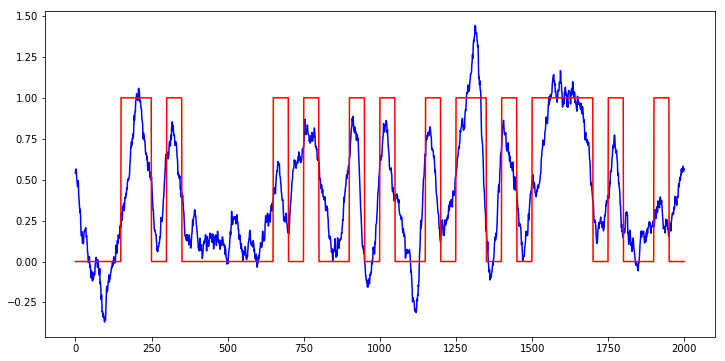

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(111)
print(len(predictedTarget))
# plt.plot(predictedParity[66600:66800])
plt.plot(predictedTarget[6000:8000],"b")
plt.plot(test_targets[6000:8000], "r")
plt.show()

In [21]:
##### Plot the output of different sized ESNs with optimal parameters
## "First module"= bigESN with 50 Neurons
## modular Approach
## bigESN with 100 Neurons
import Parity_Data_Generator
import numpy as np
from newESN import ESN
import matplotlib.pyplot as plt
import time

rng = np.random.RandomState(42)

N = 4000   
n = 3       # n-parity
timescale=50

start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

#### first module
firstModuleESN = ESN(inputs=1,
                      neurons=50,  
                      spectral_radius=0.73,  # high spectral rad is better (high fluctuations 0->1->0)
                      leak_rate= 0.41,   # adjust leak_rate
                      dt= 0.1,
                      sparsity=0.95,
                      noise=0.01,
                      input_scale=2,
                      input_shift=-1)
firstModuleESN.train(train_bits, train_targets)
predictedTargetFirstModule = firstModuleESN.predict(test_bits)
# print("Testing error first module")
test_error_FirstModule = np.sqrt(np.mean((predictedTargetFirstModule - test_targets) ** 2))

##### modular ESN
train_predicted_parity = firstModuleESN.predict(train_bits, readout_weights=np.eye(50))
test_predicted_parity = firstModuleESN.predict(test_bits, readout_weights=np.eye(50))
modularESN= ESN(inputs=50,
                      neurons=50,  
                      spectral_radius=0.52,  # high spectral rad is better (high fluctuations 0->1->0)
                      leak_rate= 0.41,   # adjust leak_rate
                      dt= 0.1,
                      sparsity=0.7,
                      noise=0.01,
                      input_scale=0.85,
                      input_shift=0)
modularESN.train(train_predicted_parity, train_targets)
predictedTargetModularESN = modularESN.predict(test_predicted_parity)
test_error_modularESN = np.sqrt(np.mean((predictedTargetModularESN - test_targets) ** 2))

##### bigESN
bigESN = ESN(inputs=1,
                      neurons=100,  
                      spectral_radius=0.73,  # high spectral rad is better (high fluctuations 0->1->0)
                      leak_rate= 0.41,   # adjust leak_rate
                      dt= 0.1,
                      sparsity=0.95,
                      noise=0.01,
                      input_scale=2,
                      input_shift=-1)
bigESN.train(train_bits, train_targets)
predictedTargetbigESN = bigESN.predict(test_bits)
# print("Testing error first module")
test_error_bigESN = np.sqrt(np.mean((predictedTargetbigESN - test_targets) ** 2))
print("Error firstModule", test_error_FirstModule)
print("Error modularESN", test_error_modularESN)
print("Error bigESN", test_error_bigESN)
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:
C:\Users\Kevin\Documents\Python-projects\BA-ESN\newESN.py:59: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if readout_weights == None:


Error firstModule 0.367428617748
Error modularESN 0.284334088977
Error bigESN 0.22109335308
--- 19.70883822441101 seconds ---


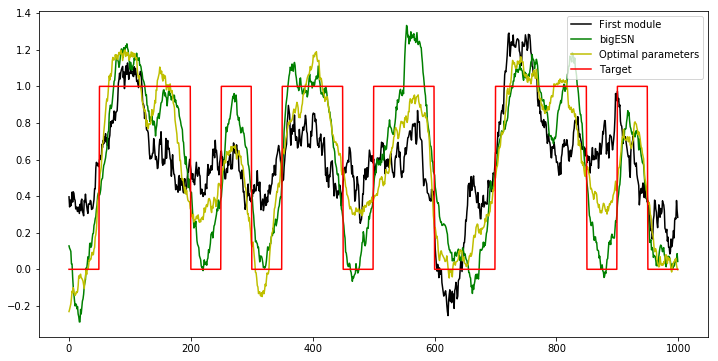

In [24]:
plt.figure(figsize=(12,6))
# plt.plot(predictedParity[66600:66800])
plt.plot(predictedTargetFirstModule[15500:16500],"black", label="First module")
plt.plot(predictedTargetbigESN[15500:16500],"g", label="bigESN")
plt.plot(predictedTargetModularESN[15500:16500],"b", label="Optimal parameters")
plt.plot(test_targets[15500:16500], "r", label="Target")
plt.legend()
plt.show()

In [25]:
######### Try changing parameters of first and second module
#### first module
normalFirstModuleESN = ESN(inputs=1,
                      neurons=50,  
                      spectral_radius=1.58,  # high spectral rad is better (high fluctuations 0->1->0)
                      leak_rate= 0.41,   # adjust leak_rate
                      dt= 0.1,
                      sparsity=0.95,
                      noise=0.01,
                      input_scale=2,
                      input_shift=-1)

##### normalModularESN
train_predicted_parity = normalFirstModuleESN.predict(train_bits, readout_weights=np.eye(50))
test_predicted_parity = normalFirstModuleESN.predict(test_bits, readout_weights=np.eye(50))
normalModularESN= ESN(inputs=50,
                      neurons=50,  
                      spectral_radius=1.58,  # high spectral rad is better (high fluctuations 0->1->0)
                      leak_rate= 1.03,   # adjust leak_rate
                      dt= 0.1,
                      sparsity=0.7,
                      noise=0.01,
                      input_scale=0.85,
                      input_shift=0)
normalModularESN.train(train_predicted_parity, train_targets)
predictedTargetnormalModularESN = normalModularESN.predict(test_predicted_parity)
test_error_normalModularESN = np.sqrt(np.mean((predictedTargetnormalModularESN - test_targets) ** 2))

###### changed parameter ESN
swappedFirstModuleESN = ESN(inputs=1,
                      neurons=50,  
                      spectral_radius=1.58,  # high spectral rad is better (high fluctuations 0->1->0)
                      leak_rate= 1.03,   # adjust leak_rate
                      dt= 0.1,
                      sparsity=0.95,
                      noise=0.01,
                      input_scale=2,
                      input_shift=-1)

##### normalModularESN
train_predicted_parity = swappedFirstModuleESN.predict(train_bits, readout_weights=np.eye(50))
test_predicted_parity = swappedFirstModuleESN.predict(test_bits, readout_weights=np.eye(50))
swappedModularESN= ESN(inputs=50,
                      neurons=50,  
                      spectral_radius=1.58,  # high spectral rad is better (high fluctuations 0->1->0)
                      leak_rate= 0.41,   # adjust leak_rate
                      dt= 0.1,
                      sparsity=0.7,
                      noise=0.01,
                      input_scale=0.85,
                      input_shift=0)
swappedModularESN.train(train_predicted_parity, train_targets)
predictedTargetswappedModularESN = swappedModularESN.predict(test_predicted_parity)
test_error_swappedModularESN = np.sqrt(np.mean((predictedTargetswappedModularESN - test_targets) ** 2))
print("Error Normal modularESN", test_error_normalModularESN)
print("Error swapped Parameters Modular ESN", test_error_swappedModularESN)

C:\Users\Kevin\Documents\Python-projects\BA-ESN\newESN.py:59: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if readout_weights == None:
C:\Users\Kevin\Documents\Python-projects\BA-ESN\BlockedLeastSquares.py:101: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._LHS == None:


Error Normal modularESN 0.327739225058
Error swapped Parameters Modular ESN 0.444176463841


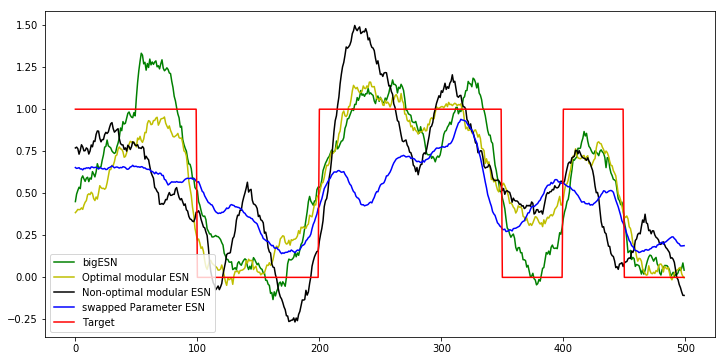

In [31]:
plt.figure(figsize=(12,6))
# plt.plot(predictedParity[66600:66800])
plt.plot(predictedTargetbigESN[16000:16500],"g", label="bigESN")
plt.plot(predictedTargetModularESN[16000:16500],"y", label="Optimal modular ESN")
plt.plot(predictedTargetnormalModularESN[16000:16500],"black", label="Non-optimal modular ESN")
plt.plot(predictedTargetswappedModularESN[16000:16500],"b", label="swapped Parameter ESN")
plt.plot(test_targets[16000:16500], "r", label="Target")
plt.legend(loc=3)
plt.show()